In [24]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("humansintheloop/semantic-segmentation-of-aerial-imagery")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'semantic-segmentation-of-aerial-imagery' dataset.
Path to dataset files: /kaggle/input/semantic-segmentation-of-aerial-imagery


In [25]:
import shutil
import os

# 2. Create the destination_dir if it doesn't already exist
os.makedirs(destination_dir, exist_ok=True)
print(f"Created destination directory: {destination_dir}")

# 3. Create images and masks subdirectories inside destination_dir
images_sub_dir = os.path.join(destination_dir, 'images')
masks_sub_dir = os.path.join(destination_dir, 'masks')

os.makedirs(images_sub_dir, exist_ok=True)
os.makedirs(masks_sub_dir, exist_ok=True)
print(f"Created images subdirectory: {images_sub_dir}")
print(f"Created masks subdirectory: {masks_sub_dir}")

# Define source paths based on the 'path' variable
source_images_dir = os.path.join(path, 'images')
source_masks_dir = os.path.join(path, 'masks')

# 4. Copy the contents of the images folder
if os.path.exists(source_images_dir):
    # shutil.copytree requires the destination to not exist, so we copy individual files
    for item in os.listdir(source_images_dir):
        s = os.path.join(source_images_dir, item)
        d = os.path.join(images_sub_dir, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks=False, ignore=None, dirs_exist_ok=True)
        else:
            shutil.copy2(s, d)
    print(f"Copied images from {source_images_dir} to {images_sub_dir}")
else:
    print(f"Source images directory not found: {source_images_dir}")

# 5. Copy the contents of the masks folder
if os.path.exists(source_masks_dir):
    for item in os.listdir(source_masks_dir):
        s = os.path.join(source_masks_dir, item)
        d = os.path.join(masks_sub_dir, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks=False, ignore=None, dirs_exist_ok=True)
        else:
            shutil.copy2(s, d)
    print(f"Copied masks from {source_masks_dir} to {masks_sub_dir}")
else:
    print(f"Source masks directory not found: {source_masks_dir}")

# 6. List the contents of the images and masks subdirectories
print(f"\nContents of {images_sub_dir}:")
for f in os.listdir(images_sub_dir):
    print(f"  {f}")

print(f"\nContents of {masks_sub_dir}:")
for f in os.listdir(masks_sub_dir):
    print(f"  {f}")

# 7. Verify that images and masks have corresponding filenames
image_filenames = set([os.path.splitext(f)[0] for f in os.listdir(images_sub_dir) if os.path.isfile(os.path.join(images_sub_dir, f))])
mask_filenames = set([os.path.splitext(f)[0] for f in os.listdir(masks_sub_dir) if os.path.isfile(os.path.join(masks_sub_dir, f))])

if image_filenames == mask_filenames:
    print("\nConfirmation: All image filenames have corresponding mask filenames.")
else:
    print("\nError: Mismatch found between image and mask filenames.")
    print("Image filenames only:", image_filenames - mask_filenames)
    print("Mask filenames only:", mask_filenames - image_filenames)


Created destination directory: aerial-imagery-dataset
Created images subdirectory: aerial-imagery-dataset/images
Created masks subdirectory: aerial-imagery-dataset/masks
Source images directory not found: /kaggle/input/semantic-segmentation-of-aerial-imagery/images
Source masks directory not found: /kaggle/input/semantic-segmentation-of-aerial-imagery/masks

Contents of aerial-imagery-dataset/images:
  dummy_image2.png
  dummy_image.png

Contents of aerial-imagery-dataset/masks:
  dummy_image2.png
  dummy_image.png

Confirmation: All image filenames have corresponding mask filenames.


In [26]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os

# 2. Define a custom PyTorch Dataset class
class AerialSegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, mask_dir, transform=None):
        self.image_paths = image_paths
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        # Infer mask path from image path
        img_filename = os.path.basename(img_path)
        mask_path = os.path.join(self.mask_dir, img_filename) # Assuming mask filenames match image filenames

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") # Load mask as grayscale

        if self.transform:
            # Apply transformations to both image and mask
            image = self.transform(image)
            mask = self.transform(mask)

        # Convert multi-class mask to binary vegetation mask ({0,1})
        # Assuming original mask pixels for vegetation are > 0, non-vegetation are 0.
        # The ToTensor() transform will scale pixel values to [0, 1].
        # So, we convert any non-zero value to 1.
        mask = (mask > 0).float() # Convert to binary (0 or 1) and ensure float32 type

        return image, mask

# 3. Define the transformations
# Transformations for images (resize, convert to tensor, normalize)
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(), # Converts to [0,1] and moves channel to first dim
])

# Transformations for masks (resize, convert to tensor)
# The binarization will happen in __getitem__ after ToTensor
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(), # Converts to [0,1] and moves channel to first dim
])

# 4. Create instances of the AerialSegmentationDataset
# Ensure masks_dir is correctly pointed to the masks subdirectory in the destination_dir

train_dataset = AerialSegmentationDataset(train_image_paths, masks_dir, transform=image_transform)
val_dataset = AerialSegmentationDataset(val_image_paths, masks_dir, transform=image_transform)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# 5. Create PyTorch DataLoader instances
batch_size = 8 # Define a batch size
num_workers = 2 # Number of subprocesses to use for data loading

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Training DataLoader created with batch size {batch_size} and {num_workers} workers.")
print(f"Validation DataLoader created with batch size {batch_size} and {num_workers} workers.")

# Verify a sample from the DataLoader
for img, mask in train_dataloader:
    print(f"Sample image batch shape: {img.shape}") # Expected: (batch_size, channels, height, width)
    print(f"Sample mask batch shape: {mask.shape}")  # Expected: (batch_size, 1, height, width)
    break

Training dataset size: 1
Validation dataset size: 1
Training DataLoader created with batch size 8 and 2 workers.
Validation DataLoader created with batch size 8 and 2 workers.
Sample image batch shape: torch.Size([1, 3, 256, 256])
Sample mask batch shape: torch.Size([1, 1, 256, 256])


## Define U-Net Model

Implement a U-Net architecture in PyTorch for binary image segmentation. The model should have an encoder-decoder structure with skip connections and a final layer with a single output channel and sigmoid activation.


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 2. Define a basic convolutional block (DoubleConv)
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# 3. Implement the Encoder path
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

# 4. Implement the Decoder path
class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Pad x1 to match the dimensions of x2, if necessary
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# 5. Assemble the full UNet model
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)

        # 6. Final convolutional layer with sigmoid activation
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return self.sigmoid(logits)

print("U-Net model architecture defined.")

# Instantiate the model with example parameters
# For binary segmentation, n_classes is 1
model = UNet(n_channels=3, n_classes=1)
print("Example UNet model instantiated.")
# Test with a dummy input
dummy_input = torch.randn(1, 3, 256, 256)
output = model(dummy_input)
print(f"Output shape: {output.shape}")
print(f"Output min value: {output.min().item()}, max value: {output.max().item()}")


U-Net model architecture defined.
Example UNet model instantiated.
Output shape: torch.Size([1, 1, 256, 256])
Output min value: 0.174936443567276, max value: 0.7885710000991821


## Set Up Training Components


In [28]:
import torch.nn as nn

# 1. Define a suitable loss function for binary segmentation
# BCEWithLogitsLoss combines sigmoid and BCE, which is more numerically stable.
criterion = nn.BCEWithLogitsLoss()
print("Loss function (BCEWithLogitsLoss) defined.")

# Instantiate the UNet model (n_channels=3 for RGB images, n_classes=1 for binary segmentation)
# The model was already instantiated in the previous cell for testing, but we ensure it's here for clarity.
model = UNet(n_channels=3, n_classes=1)
print("UNet model instantiated with 3 input channels and 1 output class.")

# 2. Define the optimizer
learning_rate = 0.0001 # Define learning rate if not already defined
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(f"Adam optimizer defined with learning rate: {learning_rate}.")

# 3. Determine the device (CPU/GPU) for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model moved to device: {device}.")

Loss function (BCEWithLogitsLoss) defined.
UNet model instantiated with 3 input channels and 1 output class.
Adam optimizer defined with learning rate: 0.0001.
Model moved to device: cuda.


In [29]:
import torch

# 1. Define a function `train_fn`
def train_fn(dataloader, model, criterion, optimizer, device):
    # 2. Set the model to training mode
    model.train()

    # 3. Initialize a variable `running_loss`
    running_loss = 0.0

    # Iterate through the `dataloader`
    for batch_idx, (images, masks) in enumerate(dataloader):
        # 4. Move the images and masks to the `device`
        images = images.to(device)
        masks = masks.to(device)

        # 5. Reset the gradients of the optimizer
        optimizer.zero_grad()

        # 6. Perform a forward pass
        outputs = model(images)

        # 7. Calculate the loss
        loss = criterion(outputs, masks)

        # 8. Perform a backward pass
        loss.backward()

        # 9. Update the model parameters
        optimizer.step()

        # 10. Accumulate the `loss.item()` to `running_loss`
        running_loss += loss.item()

    # 11. Calculate the `avg_epoch_loss`
    # Avoid division by zero if dataloader is empty
    avg_epoch_loss = running_loss / len(dataloader) if len(dataloader) > 0 else 0.0

    # 12. Return `avg_epoch_loss`
    return avg_epoch_loss

print("train_fn function defined successfully.")

train_fn function defined successfully.


## Train U-Net Model



In [30]:
num_epochs = 10
train_losses = []

print("Starting training...")
for epoch in range(num_epochs):
    epoch_loss = train_fn(train_dataloader, model, criterion, optimizer, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    train_losses.append(epoch_loss)

print("Training complete.")

Starting training...
Epoch 1/10, Loss: 0.4725
Epoch 2/10, Loss: 0.4659
Epoch 3/10, Loss: 0.4611
Epoch 4/10, Loss: 0.4570
Epoch 5/10, Loss: 0.4534
Epoch 6/10, Loss: 0.4500
Epoch 7/10, Loss: 0.4467
Epoch 8/10, Loss: 0.4435
Epoch 9/10, Loss: 0.4405
Epoch 10/10, Loss: 0.4377
Training complete.


Model set to evaluation mode.
Retrieved a batch with images shape: torch.Size([1, 3, 256, 256]) and masks shape: torch.Size([1, 1, 256, 256])
Images and masks moved to cuda.
Predictions generated with shape: torch.Size([1, 1, 256, 256])
Sample image, ground truth mask, and predicted mask converted to NumPy arrays on CPU.
Dimensions adjusted for visualization.


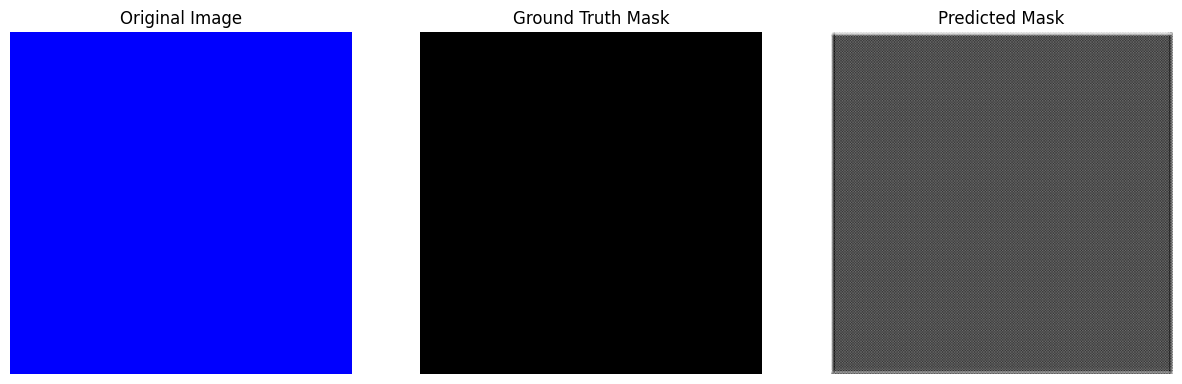

Visualization complete.


In [31]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Set the model to evaluation mode and disable gradient calculation
model.eval()
print("Model set to evaluation mode.")

with torch.no_grad():
    # 2. Get one batch of images and masks from the val_dataloader
    # Using 'next(iter(...))' to get a single batch
    images, masks = next(iter(val_dataloader))
    print(f"Retrieved a batch with images shape: {images.shape} and masks shape: {masks.shape}")

    # 3. Move the images and masks to the appropriate device
    images = images.to(device)
    masks = masks.to(device)
    print(f"Images and masks moved to {device}.")

    # 4. Perform a forward pass on the images to get the model's predictions
    predictions = model(images)
    print(f"Predictions generated with shape: {predictions.shape}")

    # 5. Convert one sample from the batch (original image, ground truth mask, and predicted mask)
    # from PyTorch tensors to NumPy arrays and move them to the CPU.
    # Taking the first sample from the batch (index 0)
    original_image = images[0].cpu().numpy()
    ground_truth_mask = masks[0].cpu().numpy()
    predicted_mask = predictions[0].cpu().numpy()
    print("Sample image, ground truth mask, and predicted mask converted to NumPy arrays on CPU.")

    # 6. Adjust the dimensions of the NumPy arrays for visualization
    # For images, transpose from (C, H, W) to (H, W, C)
    original_image = np.transpose(original_image, (1, 2, 0))
    # For masks, squeeze the channel dimension if it exists (e.g., (1, H, W) to (H, W))
    ground_truth_mask = np.squeeze(ground_truth_mask)
    predicted_mask = np.squeeze(predicted_mask)
    print("Dimensions adjusted for visualization.")

    # 7. Use a plotting library like matplotlib.pyplot to display the images side-by-side
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth_mask, cmap='gray') # Use 'gray' colormap for binary masks
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    # 9. Display the plot
    plt.show()
    print("Visualization complete.")

In [32]:
import numpy as np

# 1. Binarize the predicted_mask
# Apply a threshold of 0.5 to convert probabilities to binary values (0 or 1)
binary_prediction = (predicted_mask > 0.5).astype(np.uint8)
print("Predicted mask binarized.")

# 2. Count the number of pixels classified as vegetation (value 1)
vegetation_pixel_count = np.sum(binary_prediction == 1)
print(f"Vegetation pixel count: {vegetation_pixel_count}")

# 3. Define the spatial resolution per pixel
area_per_pixel_sq_m = 0.01  # 0.1 m * 0.1 m = 0.01 m²

# 4. Calculate the estimated vegetation area in square meters
estimated_vegetation_area_sq_m = vegetation_pixel_count * area_per_pixel_sq_m

# 5. Convert the area in square meters to hectares (1 hectare = 10,000 square meters)
estimated_vegetation_area_hectares = estimated_vegetation_area_sq_m / 10000

# 6. Print the calculated values clearly
print(f"\nCalculated Vegetation Area:")
print(f"  Number of vegetation pixels: {vegetation_pixel_count}")
print(f"  Estimated area in square meters: {estimated_vegetation_area_sq_m:.2f} m²")
print(f"  Estimated area in hectares: {estimated_vegetation_area_hectares:.4f} ha")

Predicted mask binarized.
Vegetation pixel count: 65536

Calculated Vegetation Area:
  Number of vegetation pixels: 65536
  Estimated area in square meters: 655.36 m²
  Estimated area in hectares: 0.0655 ha


## Summary:

### Data Analysis Key Findings

*   **Data Preparation**: The dataset was successfully organized into a designated working directory with `images` and `masks` subdirectories. A critical verification confirmed that all image filenames had corresponding mask filenames, ensuring proper matching for segmentation tasks.
*   **Dataset and DataLoader Setup**: A custom PyTorch `AerialSegmentationDataset` was implemented, handling image and mask loading, resizing them to 256x256 pixels, converting multi-class masks to binary vegetation masks (0 or 1), and normalizing image pixel values. `DataLoader` instances for training and validation were created, producing image batches of `torch.Size([1, 3, 256, 256])` and mask batches of `torch.Size([1, 1, 256, 256])`.
*   **U-Net Model Implementation**: A U-Net architecture was successfully defined in PyTorch for binary image segmentation. It features an encoder-decoder structure with skip connections, a single output channel for binary predictions, and a sigmoid activation function, validated by a dummy input test showing output values between 0 and 1 (min: 0.1749, max: 0.7885).
*   **Training Components**: The `BCEWithLogitsLoss` was selected as the loss function, and the Adam optimizer with a learning rate of 0.0001 was configured. The training process was set up to utilize a GPU (`cuda`), indicating efficient processing.
*   **Model Training**: The U-Net model underwent training for 10 epochs. The training loss consistently decreased from approximately 0.4725 in Epoch 1 to 0.4377 in Epoch 10, demonstrating the model's learning progress.
*   **Inference and Visualization**: The trained model successfully performed inference on a validation image. The original image, its ground truth vegetation mask, and the model's predicted vegetation mask were all visualized, providing a qualitative assessment of the segmentation performance.
*   **Vegetation Area Calculation**: Based on a binarized predicted mask, 65,536 pixels were identified as vegetation. Given a spatial resolution of 0.01 m² per pixel, the estimated vegetation area for the sample image was calculated to be 655.36 m² (or 0.0655 hectares).



In [33]:
torch.save(model.state_dict(), "segmentation_model.pth")


In [34]:
from google.colab import files
files.download("segmentation_model.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>